# Analyse one recording 

In [1]:
import numpy as np
from tqdm import tqdm
import librosa
import librosa.display
import librosa.util
import matplotlib.pyplot as plt

## Global settings
__Important:__ These settings have to match the ones in the STM32 application.

In [2]:
# Sampling
sampling_freq = 48000 # kHz 
n_stft_columns = 32 # How many columns for the short time fourier transformation
frame_size = 512*n_stft_columns + 512 # For one spectrogram column 1024 samples are needed

# Realtime audio preprocessing
n_mels = 30 # Resolution (bins) of one stft column
n_fft = 1024 # Size for one fft
hop_length = 512 # Jumps between fft windows
fmin = 5000 # Lowest bin for the columns
top_db = 80

## Import and convert the data

In [13]:
signal, _ = librosa.load('MIC002.WAV', sr=sampling_freq, mono=True, dtype=np.float32)

n_frames = int(len(signal) / frame_size)

print("signal length: ", len(signal))
print("number of frames: ", n_frames)

signal length:  337920
number of frames:  20


## Slice the data

In [14]:
FilterStartIndices = []
FilterStopIndices = []

def FilterBankInit():
    start_idx = 107;
    
    for i in range(n_mels):
        FilterStartIndices.append(start_idx);
        
        freq_bin = 5300 + i * 600;

        for j in range(start_idx,int(n_fft/2+1)):
            fft_freq = 48000 / 1024 * j;

            if (abs(freq_bin-fft_freq) > 300):
                start_idx = j;
                FilterStopIndices.append(j)
                break;


FilterBankInit()

print(FilterStartIndices)
print(FilterStopIndices)



def FilterBank(STFT):
    S = np.zeros((n_mels, 32))
    for i in range(n_mels):
        start_idx = FilterStartIndices[i]
        stop_idx = FilterStopIndices[i]

        for k in range(32):
            sum = 0
            for j in range(start_idx, stop_idx):
                sum += STFT[j,k];

            S[i, k] = sum;
    return S

[107, 120, 133, 146, 158, 171, 184, 197, 210, 222, 235, 248, 261, 274, 286, 299, 312, 325, 338, 350, 363, 376, 389, 402, 414, 427, 440, 453, 466, 478]
[120, 133, 146, 158, 171, 184, 197, 210, 222, 235, 248, 261, 274, 286, 299, 312, 325, 338, 350, 363, 376, 389, 402, 414, 427, 440, 453, 466, 478, 491]


In [15]:
signal_framed = []

# Iteratate over recording and create frames
for k  in range(n_frames):
    frame = signal[k*frame_size:(k+1)*frame_size]
    signal_framed.append(np.transpose(frame))
    
# Convert into numpy array
signal_framed = np.asarray(signal_framed)

print("signal_framed shape: ", signal_framed.shape)

signal_framed shape:  (20, 16896)


## Preprocess the data into a spectrogram of the STFT

In [16]:
# Spectograms of frames which will be the feautures for the neural network
signal_features = []

for frame in tqdm(signal_framed):
    # Create a mel-scaled spectrogram
    STFT = np.abs(librosa.stft(y=frame, n_fft=1024, hop_length=hop_length, window='hann', center=False, dtype=None))
    S = FilterBank(STFT) # Why 513?O

    
    # Scale according to reference power
    S = S / S.max()
    # Convert to dB
    S_log = librosa.power_to_db(S, top_db=top_db)
    signal_features.append(S_log)


# Convert into numpy array
signal_features = np.asarray(signal_features)

print("signal_features shape: ", signal_features.shape)

100%|██████████| 20/20 [00:00<00:00, 84.73it/s]

signal_features shape:  (20, 30, 32)


## Plot spectrogram of a frames

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


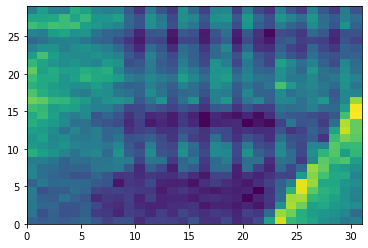

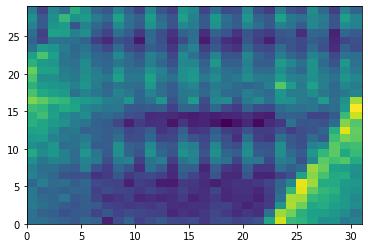

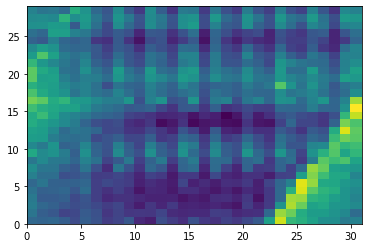

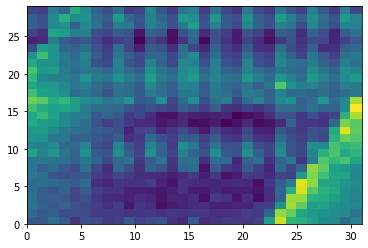

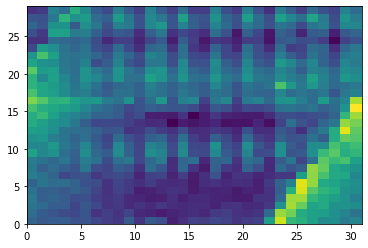

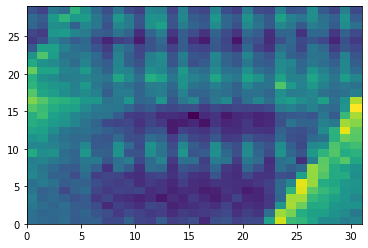

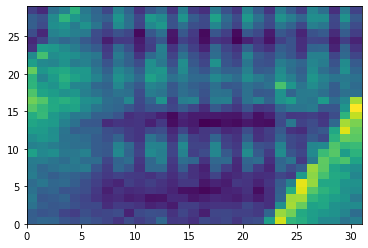

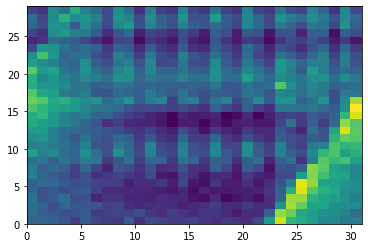

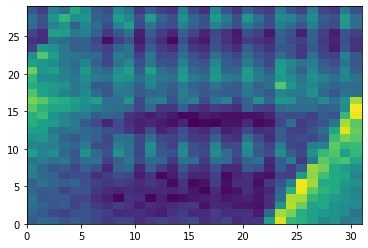

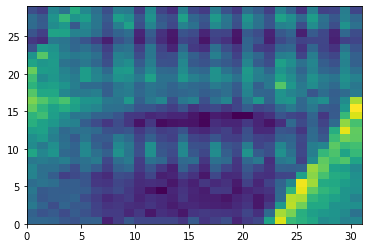

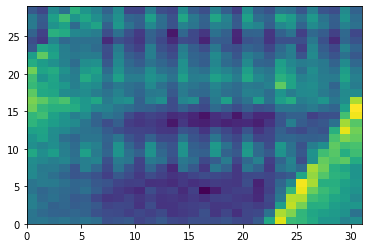

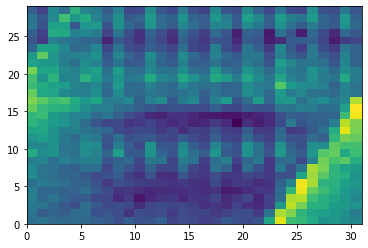

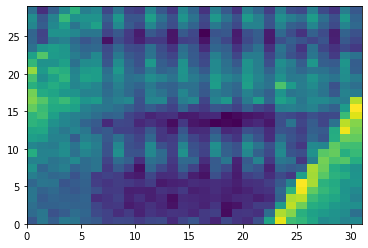

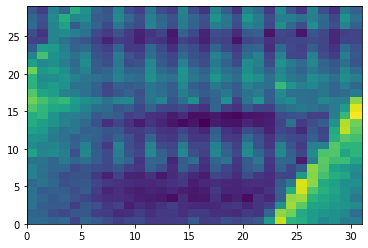

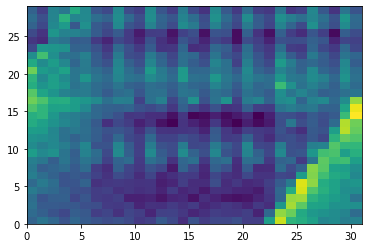

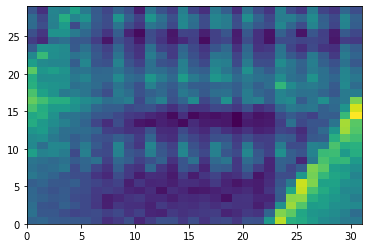

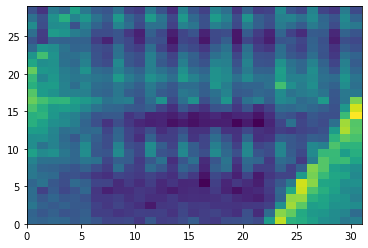

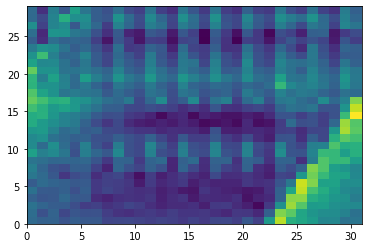

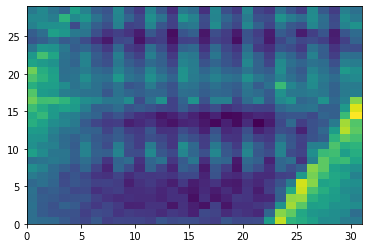

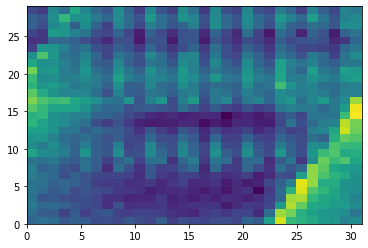

In [17]:
for frame_number in range(n_frames):
    z = signal_features[frame_number, :, :]
    z = z.transpose()

    x, y = np.mgrid[:32, :30]

    fig, ax = plt.subplots()
    ax.pcolormesh(x, y, z)
    plt.show()